In [1]:
import numpy as np
import pandas as pd
import glob
import random
import segyio
import seaborn as sn 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [73]:
def segyToNumpy(filepath, n_inlines, n_crosslines, n_samples):
    SV = np.zeros((n_inlines, n_crosslines, n_samples))
    with segyio.open(filepath, ignore_geometry=True) as f:
        inline_index = segyio.TraceField.INLINE_3D
        crossline_index = segyio.TraceField.CROSSLINE_3D
        iStart=f.header[0][inline_index]
        xStart=f.header[0][crossline_index]

        for i in range(len(f.trace)):
            header = f.header[i]
            inline_num = header[inline_index]
            crossline_num = header[crossline_index]
            SV[inline_num - iStart, crossline_num - xStart,:] = f.trace[i]
            
    return SV

def npyToSegy(volume, path):
    volume = volume.astype(np.float32)
    ilines = volume.shape[0]
    xlines = volume.shape[1]
    samples = volume.shape[2]
    
    istart = 100
    xstart = 300
    sample_interval = 4  # Sample interval in milliseconds

    spec = segyio.spec()
    spec.ilines  = np.arange(istart, istart + ilines, 1)
    spec.xlines  = np.arange(xstart, xstart + xlines, 1)
    spec.samples = np.linspace(0, int((samples-1) * sample_interval), samples)
    spec.sorting = 2
    spec.format  = 1
    spec.tracecount = len(spec.ilines) * len(spec.xlines)
    
    with segyio.create(path + ".sgy", spec) as f:
        pbar = tqdm(total=ilines*xlines, desc="Saving Volume", unit="trace")
        for i, iline in enumerate(spec.ilines):
            for j, xline in enumerate(spec.xlines):
                trace_idx = i * len(spec.xlines) + j  # Calculate the trace index in flat form
                f.trace[trace_idx] = volume[i, j, :]  # Fill each trace with the corresponding volume
                pbar.update(1)
                
        pbar.close()
        
        # Set textual header
        pbar = tqdm(total=spec.tracecount, desc="Setting textual header", unit="trace")
        f.text[0] = segyio.tools.wrap(f"SEGY file created with ilines and xlines.")
        
        # Optionally, set headers for each trace
        for trace_idx in range(spec.tracecount):
            f.header[trace_idx] = {
                segyio.TraceField.INLINE_3D: spec.ilines[trace_idx // len(spec.xlines)],
                segyio.TraceField.CROSSLINE_3D: spec.xlines[trace_idx % len(spec.xlines)]
            }
            pbar.update(1)
            
        pbar.close()
        print(f"SEG-Y file created successfully at: {path}")

In [3]:
def plot2D(image,title='2Dfront',p='seismic'):
    sn.set(rc={'figure.figsize':(20,12)})
    hm = sn.heatmap(data = image,cmap=p) 
    plt.title(title)
    plt.show()

def plots(images,label=False):
    if(len(images)==1):
        return plot(images[0],label)
        
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i in range(len(images)):
        sn.heatmap(images[i], ax=axes[i], cmap='seismic',cbar=False,xticklabels=label,  yticklabels=label)
        
    plt.tight_layout()
    plt.show()

In [41]:
def cleanDataFrame(df, columns):
    for i in range(len(columns)):
        df = df.drop(df[(df[columns[i]] == 1.000000e+30)].index)
        
    df = df.reset_index()[columns]
    return df

def resampleLogs(logs, timeDepthTabele, samplingInterval, zSamples):
    resampledLogs = []
    for i in range(len(logs)):
        resampledLogs.append(resamplingOnTime(logs[i], tdts[i], samplingInterval, zSamples))

    return resampledLogs

def replaceInfinitiesInDataFrame(df, columns):
    newDf = pd.DataFrame()
    for i in range(len(columns)):
        value = 0
        for x in df[columns[i]]:
            if x != 1.000000e+30:
                value = x
                break
            
        newDf[columns[i]] = df[columns[i]].replace(1.000000e+30, value)
        
    return newDf

def replaceLogsInfinities(logs):
    definedLogs = []
    for i in range(len(logs)):
        definedLogs.append(replaceInfinitiesInDataFrame(logs[i], logs[i].columns))

    return definedLogs

In [42]:
# def getPointsAndValues(zIndex, logs, locations):
#     pointsValues = []
#     knownPoints = locations
#     for i in range(len(logs)):
#         pointsValues.append([logs[i][zIndex]])

#     return knownPoints, pointsValues

# def inverseDistanceZSlice(zSliceShape, knownPoints, pointsValues, power=1):
#     interpolatedZSlice = np.zeros(zSliceShape)
#     for crossline in range(zSliceShape[0]):
#         for inline in range(zSliceShape[1]):
#             weights = weightsForKnownPoints(knownPoints, (inline, crossline), p = power)
#             weighted_average = np.sum(weights * pointsValues) / np.sum(weights)
#             interpolatedZSlice.T[inline][crossline] = weighted_average
            
#     return interpolatedZSlice
    
# def zSliceInterpolation(volumeShape, logs, locations, power=1):
#     pbar = tqdm(total=volumeShape[2], desc="Interpolating Volume", unit="Z Slice", leave=True, position=0)
#     interpolatedVolume = np.zeros(volumeShape)
#     for z in range(volumeShape[2]):
#         zSliceShape = (volumeShape[1], volumeShape[0])
#         knownPoints, pointsValues = getPointsAndValues(z, logs, locations)
#         interpolatedZSlice = inverseDistanceZSlice(zSliceShape, knownPoints, pointsValues, power)
#         interpolatedVolume.T[z] = interpolatedZSlice
#         pbar.update(1)

#     pbar.close()
#     return interpolatedVolume

# def fillHorizonForMissingValues(horizon):
#     inlineRange = range(0, 651)
#     crosslineRange = range(0, 951)
#     full_grid = pd.MultiIndex.from_product([inlineRange, crosslineRange], names=['Inline', 'Crossline']).to_frame(index=False)
#     result = full_grid.merge(horizon, on=['Inline', 'Crossline'], how='left')
    
#     return result

In [43]:
def pdToNpHorizon(pdHorizon):
    horizon = np.zeros((651, 951))
    for i in range(len(horizon)):
        horizon[i] = pdHorizon[pdHorizon["Inline"] == i]["Index"]

    return horizon
    
def timeToIndexConvertor(timeArray):
    timeValues = np.linspace(0, 1848, 463)
    indexValues = np.linspace(0, 463, 463)
    indexArray = np.interp(timeArray, timeValues, indexValues)
    return indexArray

def weightsForKnownPoints(knownPoints, targetPoint):
    distances = np.sum((knownPoints - targetPoint) ** 2, axis=1)
    return 1 / np.where(distances == 0, 1e-10, distances)
    
def horizonsValuesAtWellLocations(wellLocations, numpyHorizons):
    horizonValuesAtWells = np.zeros((len(wellLocations), len(numpyHorizons)))
    for i in range(len(wellLocations)):
        for j in range(len(numpyHorizons)):
            horizonValuesAtWells[i][j] = numpyHorizons[j][wellLocations[i][0]][wellLocations[i][1]]
            
    return horizonValuesAtWells

def getHorizonDistanceRatioFromZIndexValues(zIndexValues, z):
    index = np.searchsorted(zIndexValues, z)
    h1DistanceRatio = abs((zIndexValues[index-1]-z)/(zIndexValues[index-1]-zIndexValues[index]))
    
    return index-1, h1DistanceRatio

def getWellValuesFromHorizonRatio(z, zIndexValues, horizonsValuesAtWells, timeValues, logs):
    h1Index, ratio = getHorizonDistanceRatioFromZIndexValues(zIndexValues, z)
    h2Index = h1Index + 1
    z1Indexes = horizonsValuesAtWells[:, h1Index]
    z2Indexes = horizonsValuesAtWells[:, h2Index]
    zValues = z1Indexes + ratio * (z2Indexes - z1Indexes)
    logTimeValues = np.interp(zValues, [0, 463], [0, 1848])
    curveValuesAtWells = np.zeros(len(logs))
    for i in range(len(logs)):
        curveValuesAtWells[i] = np.interp(logTimeValues[i], timeValues, logs[i])

    return curveValuesAtWells

In [44]:
def horizonInterpolation(volumeShape, numpyHorizons, wellLocations, logs, allWeights, allZIndexValues):
    volume = np.zeros(volumeShape)
    horizonsValuesAtWells = horizonsValuesAtWellLocations(wellLocations, numpyHorizons)
    timeValues = np.linspace(0, 1848, 463)
    inlines = volumeShape[0]
    crosslines = volumeShape[1]
    sample = volumeShape[2]
    pbar = tqdm(total=inlines, desc="Generating horizon interpolated volume", unit=" Inlines", leave=True, position=0)
    for i in range(inlines):
        for x in range(crosslines):
            weights = np.array([allWeights[i][x] for z in range(sample)])
            wellValues = np.array([
                getWellValuesFromHorizonRatio(z, allZIndexValues[i][x], horizonsValuesAtWells, timeValues, logs) for z in range(sample)
            ])
            volume[i, x, :] = np.sum(weights * wellValues, axis=1) / sumWeights[i][x]
            
        pbar.update(1)
                
    pbar.close()
    return volume

In [45]:
ilines = 651
xlines = 951
zSamples = 463
trace_count = ilines*xlines
volumeShape = (651, 951, 463)
istart = 100
xstart = 300
samplingInterval = 4
folder = 'Seismic'

In [74]:
cube = '4_Dip_steered_median_filter'
filepath = folder + '//' + cube + '.sgy'

seismic = segyToNumpy(filepath, ilines, xlines, zSamples)
np.shape(seismic)

(651, 951, 463)

In [46]:
well1_data = pd.read_csv('Well 1//F02-1_WellLogs.dat', delimiter='\t')
well1_D2TModel = pd.read_csv('Well 1//F02-1_D2TModel.dat', delimiter='\t')

well2_data = pd.read_csv('Well 2//F03-2_WellLogs.dat', delimiter='\t')
well2_D2TModel = pd.read_csv('Well 2//F03-2_D2TModel.dat', delimiter='\t')

well3_data = pd.read_csv('Well 3//F03-4_WellLogs.dat', delimiter='\t')
well3_D2TModel = pd.read_csv('Well 3//F03-4_D2TModel.dat', delimiter='\t')

well4_data = pd.read_csv('Well 4//F06-1_WellLogs.dat', delimiter='\t')
well4_D2TModel = pd.read_csv('Well 4//F06-1_D2TModel.dat', delimiter='\t')

In [47]:
folder_path = 'Horizons'
file_names = glob.glob(folder_path + '/*')
horizons = []
for i in [1, 2, 3, 6, 7]:
    horizon = pd.read_csv(file_names[i], delimiter='\t')
    horizons.append(horizon)

for i in range(len(horizons)):
    horizons[i]['Inline'] = horizons[i]["Inline"]-istart
    horizons[i]['Crossline'] = horizons[i]["Crossline"]-xstart
    horizons[i]['Z'] = horizons[i]['Z']*1000
    horizons[i]['Index'] = timeToIndexConvertor(horizons[i]['Z'])
    if len(horizons[i]) < 619101:
        number = len(horizons[i])
        horizons[i] = fillHorizonForMissingValues(horizons[i])
        print(f"Horizon {i+1} ({file_names[i]}):", len(horizons[i]), f"Filled with {619101-number} nan values")
    else:
        print(f"Horizon {i+1} ({file_names[i]}):", len(horizons[i]))

horizons[0].columns

Horizon 1 (Horizons\1 Shallow.dat): 619101
Horizon 2 (Horizons\2 FS8.dat): 619101
Horizon 3 (Horizons\3 FS7.dat): 619101
Horizon 4 (Horizons\4 Truncation.dat): 619101
Horizon 5 (Horizons\5 Top Foresets.dat): 619101


Index(['Inline', 'Crossline', 'Z', 'Index'], dtype='object')

In [48]:
numpyHorizons = []
for i in range(len(horizons)):
    numpyHorizons.append(pdToNpHorizon(horizons[i]))
    print(f"Horizon {i+1} converted to numpy")
numpyHorizons = np.array(numpyHorizons)
numpyHorizons.shape

Horizon 1 converted to numpy
Horizon 2 converted to numpy
Horizon 3 converted to numpy
Horizon 4 converted to numpy
Horizon 5 converted to numpy


(5, 651, 951)

In [49]:
virtualHorizon1 = numpyHorizons[0] - np.max(numpyHorizons)
virtualHorizon2 = numpyHorizons[len(numpyHorizons)-1] + zSamples - np.min(numpyHorizons)
numpyAllHorizons = np.concatenate(([virtualHorizon1], numpyHorizons, [virtualHorizon2]), axis=0)
len(numpyAllHorizons)

7

In [61]:
cols = well1_data.columns
logIndex = 1

log1 = well1_data[[cols[0], cols[logIndex]]]
log2 = well2_data[[cols[0], cols[logIndex]]]
log3 = well3_data[[cols[0], cols[logIndex]]]
log4 = well4_data[[cols[0], cols[logIndex]]]

logs = [log1, log2, log3, log4]
logs = replaceLogsInfinities(logs)

In [62]:
well1Coordinates = (362-istart, 336-xstart)
well2Coordinates = (722-istart, 848-xstart)
well3Coordinates = (442-istart, 1007-xstart)
well4Coordinates = (244-istart, 387-xstart)

locations = np.array([well1Coordinates, well2Coordinates, well3Coordinates, well4Coordinates])
tdts = [well1_D2TModel, well2_D2TModel, well3_D2TModel, well4_D2TModel]

In [63]:
def resamplingOnTime(well, timeDepthTable, samplingInterval, zSamples):
    timeAxis = np.linspace(0, int((zSamples-1) * samplingInterval), zSamples)
    tdtTimeValues = timeDepthTable["TWT(ms)"]
    tdtDepthValues = timeDepthTable["TVDSS(m)"]
    
    wellDepthValues = well[well.columns[0]]
    wellLFMValues = well[well.columns[1]]
    
    depthAxis = np.interp(timeAxis, tdtTimeValues, tdtDepthValues)
    resampledAI_LF = np.interp(depthAxis, wellDepthValues, wellLFMValues)

    resampledWell = pd.DataFrame({
        well.columns[0]: depthAxis,
        "Time": timeAxis,
        well.columns[1]: resampledAI_LF
    })

    return resampledWell

In [65]:
resampledLogs = resampleLogs(logs, tdts, samplingInterval, zSamples)

AI1 = resampledLogs[0][log1.columns[1]]
AI2 = resampledLogs[1][log2.columns[1]]
AI3 = resampledLogs[2][log3.columns[1]]
AI4 = resampledLogs[3][log4.columns[1]]

logs = np.array([AI_LF1, AI_LF2, AI_LF3, AI_LF4])

In [67]:
pbar = tqdm(total=651, desc="Fetching Weights and Index Values for Traces", unit=" Inlines", leave=True, position=0)
allWeights = np.zeros((651, 951, len(logs)))
allZIndexValues = np.zeros((651, 951, len(numpyAllHorizons)))
sumWeights = np.zeros((651, 951, 1))
for i in range(651):
    for x in range(951):
        allWeights[i][x] = weightsForKnownPoints(locations, (i, x))
        allZIndexValues[i][x] = numpyAllHorizons[:, i, x]
        sumWeights[i][x] = np.sum(allWeights[i][x])
    pbar.update(1)
pbar.close()

Fetching Weights and Index Values for Traces: 100%|████████████████████████████| 651/651 [00:26<00:00, 24.89 Inlines/s]


In [68]:
AICube = horizonInterpolation(volumeShape, numpyAllHorizons, locations, AI_LF_Logs, allWeights, allZIndexValues)

Generating horizon interpolated volume: 100%|████████████████████████████████| 651/651 [1:54:46<00:00, 10.58s/ Inlines]


In [69]:
AICube = LFM_From_Horizons_Python

In [70]:
npyToSegy(AICube, "Seismic//AICube_Python")

Setting textual header: 100%|████████████████████████████████████████████| 619101/619101 [00:15<00:00, 39909.38trace/s]


SEG-Y file created successfully at: Seismic//AICube_Python


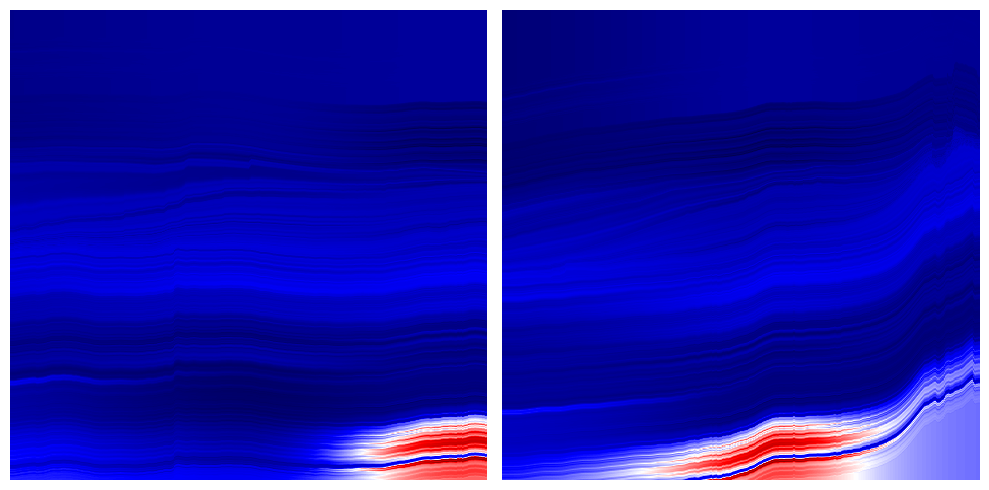

In [79]:
plots([AICube[:,600].T, AICube[600].T])